# lab session #5 
## Apprentissage d'un modèle génératif de textures `Texture-Networks` 
## avec la distance perceptuelle

<img src="Ensicaen-logo.png" alt="logo_ENSI" style="width: 200px;"/> 

### 2023 Notebook by Julien (dot) Rabin (at) ensicaen.fr
#### code adapted from Jorge Gutierrez https://github.com/JorgeGtz
#### Original Paper : "Texture Networks: Feed-forward Synthesis of Textures and Stylized Images" of Ulyanov et al. https://arxiv.org/abs/1603.03417

________________________________
### LastName / Nom : 
### Surname / Prénom : 
### Group :
### Date : 
________________________________

In this notebook, the goal is to use the neural image perceptual loss using VGG features :
- [VGG network](#0---import--define-vgg-architecture): defines the (truncated) VGG-19 model (i.e. whithout the final linear layers) is defined
- [Generative model](#1---define-the-generative-model-texture-network): defines the Texture-Network architecture
- [Perceptual Loss](#2---define-the-perceptual-loss-criterion): defines the objective function to train the network
- [Data loading](#3---initialisation-of-the-networks-generative-model-loading-data-vgg--texture-image): Loads parameters for the VGG CNN and an image (a texture sample)
- [Definition of the perceptual loss and Optimisation](#4---training-the-generative-network) performs (pixel-wise) optimization of the neural network to match the texture image statistics using the perceptual loss
- [Feed-Forward Texture Synthesis](#5---feed-forward-synthesis): after training the generative model can be sample to synthesize arbitrary large textures
- [Questions](#6---questions) some simple questions that should be addressed within the lab session
- [Exercices](#7---exercices) pick a few questions from the proposed exercice to deeppen your understanding of the method 

________________________________
## 0 - Import & Define VGG architecture


In [2]:
import sys
import datetime
import os

from shutil import copyfile
import numpy
import math
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
import torchvision
from torchvision import transforms


import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print('using CUDA !')
    device = torch.device('cuda:0')
    dtype = torch.cuda.FloatTensor
else :
    print('use CPU only :(')
    dtype = torch.FloatTensor
    device = torch.device('cpu')
    
disp = 1 # show image in notebook



In /Users/rabin/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/rabin/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/rabin/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/rabin/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/rabin/miniconda3/lib/python3.6/site-packages/m

use CPU only :(


In [3]:
# truncated vgg-19 architecture with only the 16 convolutional layers
class VGG(nn.Module):
    def __init__(self, pool='max', pad=1 ):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=pad)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=pad)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=pad)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=pad)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=pad)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=pad)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=pad)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=pad)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=pad)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=pad)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=pad)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=pad)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=pad)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=pad)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=pad)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=pad)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        # out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]



## 1 - Define the Generative model (Texture network)

In [4]:
#generator's convolutional blocks 2D
class Conv_block2D(nn.Module):
    def __init__(self, n_ch_in, n_ch_out, m=0.1):
        super(Conv_block2D, self).__init__()

        self.conv1 = nn.Conv2d(n_ch_in, n_ch_out, 3, padding=0, bias=True)
        self.bn1 = nn.BatchNorm2d(n_ch_out, momentum=m)
        self.conv2 = nn.Conv2d(n_ch_out, n_ch_out, 3, padding=0, bias=True)
        self.bn2 = nn.BatchNorm2d(n_ch_out, momentum=m)
        self.conv3 = nn.Conv2d(n_ch_out, n_ch_out, 1, padding=0, bias=True)
        self.bn3 = nn.BatchNorm2d(n_ch_out, momentum=m)

    def forward(self, x):
        x = torch.cat((x[:,:,-1,:].unsqueeze(2),x,x[:,:,0,:].unsqueeze(2)),2)
        x = torch.cat((x[:,:,:,-1].unsqueeze(3),x,x[:,:,:,0].unsqueeze(3)),3)
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = torch.cat((x[:,:,-1,:].unsqueeze(2),x,x[:,:,0,:].unsqueeze(2)),2)
        x = torch.cat((x[:,:,:,-1].unsqueeze(3),x,x[:,:,:,0].unsqueeze(3)),3)
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        return x

#Up-sampling + batch normalization block
class Up_Bn2D(nn.Module):
    def __init__(self, n_ch):
        super(Up_Bn2D, self).__init__()

        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.bn = nn.BatchNorm2d(n_ch)

    def forward(self, x):
        x = self.bn(self.up(x))
        return x

class Pyramid2D(nn.Module):
    def __init__(self, ch_in=3, ch_step=8):
        super(Pyramid2D, self).__init__()

        self.cb1_1 = Conv_block2D(ch_in,ch_step)
        self.up1 = Up_Bn2D(ch_step)

        self.cb2_1 = Conv_block2D(ch_in,ch_step)
        self.cb2_2 = Conv_block2D(2*ch_step,2*ch_step)
        self.up2 = Up_Bn2D(2*ch_step)

        self.cb3_1 = Conv_block2D(ch_in,ch_step)
        self.cb3_2 = Conv_block2D(3*ch_step,3*ch_step)
        self.up3 = Up_Bn2D(3*ch_step)

        self.cb4_1 = Conv_block2D(ch_in,ch_step)
        self.cb4_2 = Conv_block2D(4*ch_step,4*ch_step)
        self.up4 = Up_Bn2D(4*ch_step)

        self.cb5_1 = Conv_block2D(ch_in,ch_step)
        self.cb5_2 = Conv_block2D(5*ch_step,5*ch_step)
        self.up5 = Up_Bn2D(5*ch_step)

        self.cb6_1 = Conv_block2D(ch_in,ch_step)
        self.cb6_2 = Conv_block2D(6*ch_step,6*ch_step)
        self.last_conv = nn.Conv2d(6*ch_step, 3, 1, padding=0, bias=True)

    def forward(self, z):

        y = self.cb1_1(z[5])
        y = self.up1(y)
        y = torch.cat((y,self.cb2_1(z[4])),1)
        y = self.cb2_2(y)
        y = self.up2(y)
        y = torch.cat((y,self.cb3_1(z[3])),1)
        y = self.cb3_2(y)
        y = self.up3(y)
        y = torch.cat((y,self.cb4_1(z[2])),1)
        y = self.cb4_2(y)
        y = self.up4(y)
        y = torch.cat((y,self.cb5_1(z[1])),1)
        y = self.cb5_2(y)
        y = self.up5(y)
        y = torch.cat((y,self.cb6_1(z[0])),1)
        y = self.cb6_2(y)
        y = self.last_conv(y)
        return y



## 2 - Useful functions to define the Perceptual loss criterion

In [5]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2))
        # G.div_(h*w) # Gatys
        G.div_(h*w*c) # Ulyanov
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

# Identity function that normalizes the gradient on the call of backwards
# Used for "gradient normalization"
class Normalize_gradients(Function):
    @staticmethod
    def forward(self, input):
        return input.clone()
    @staticmethod
    def backward(self, grad_output):
        grad_input = grad_output.clone()
        grad_input = grad_input.mul(1./torch.norm(grad_input, p=1))
        return grad_input,


In [6]:
# pre and post processing for images (required by VGG network)
prep = transforms.Compose([
        transforms.ToTensor(),
        #turn to BGR
        transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),
        #subtract imagenet mean
        transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961],
                            std=[1,1,1]),
        transforms.Lambda(lambda x: x.mul_(255)),
        ])

postpa = transforms.Compose([
        transforms.Lambda(lambda x: x.mul_(1./255)),
        #add imagenet mean
        transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961],
                            std=[1,1,1]),
        #turn to RGB
        transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),
        ])

postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1
    t[t<0] = 0
    img = postpb(t)
    return img

## 3 - Initialisation of the Networks (Generative model), loading data (VGG & texture image)

In [7]:
vgg = VGG(pool='max', pad=1) # 'max' used in the paper, 'avg' recommended
vgg.load_state_dict(torch.load('./Models/vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
vgg.to(device)


VGG(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512,

In [8]:
img_size = 256 # 256 is recommended
n_input_ch = 3 # 3 color channels

# create generator network
gen = Pyramid2D(ch_in=3, ch_step=8)
params = list(gen.parameters())
total_parameters = 0
for p in params:
    total_parameters = total_parameters + p.data.numpy().size
print('Generator''s total number of parameters = ' + str(total_parameters))


Generators total number of parameters = 116835


In [9]:
#define folders
image_dir  = './Textures/'
input_name = 'red_peppers_256.jpg' #

# test folder, backup and results
time_info = datetime.datetime.now()
out_folder_name = time_info.strftime("%Y-%m-%d") + '_' \
                  + input_name[:-4] \
                  + '_2D' + time_info.strftime("_%H%M")

if not os.path.exists('./Trained_models/' + out_folder_name):
    os.mkdir( './Trained_models/' + out_folder_name)
copyfile('./TP_texture_networks_exercice.ipynb', './Trained_models/' + out_folder_name + '/code.ipynb')



'./Trained_models/2023-12-11_red_peppers_256_2D_1112/code.ipynb'

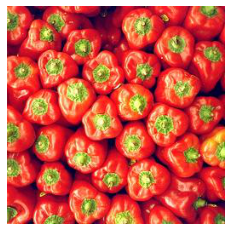

In [10]:
# load images
input_texture = Image.open(image_dir + input_name)
input_torch = Variable(prep(input_texture)).unsqueeze(0).to(device)
# display images
if disp:
    fig = plt.figure()
    img_disp = numpy.asarray(input_texture, dtype="int32")
    plt.imshow(img_disp)
    plt.axis('off')
    

## 4 - Training the generative network

#### Perceptual loss criterion

In [16]:

#define layers, loss functions, weights and compute optimization target
loss_layers = ['r52'] # using one of the last convolutional layer
loss_fns = [nn.MSELoss()] * len(loss_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]
w = [1] # list of weights corresponding to each layer
# to use with Gatys' normalization: w = [1e2/n**3 for n in [64,128,256,512,512]] with 5 layers

#compute optimization targets
targets = [f for f in vgg(input_torch, loss_layers)]


#### Perceptual loss criterion

In [17]:
# training parameters
batch_size = 4
max_iter = 101
show_iter = 10 # display image every X iterations 
save_params = 500 # save generator's parameters every 500 iterations

learning_rate = 0.1
lr_adjust = 300
lr_decay_coef = 0.8
min_lr = 0.001
# use gradient normalization
use_GN = 1


In [18]:
gen.to(device)
gen.train()

optimizer = optim.SGD(gen.parameters(), lr=learning_rate)
I = Normalize_gradients.apply
Loss = numpy.zeros(max_iter)

#### training loop

Iteration: 9, loss: 10553.321289


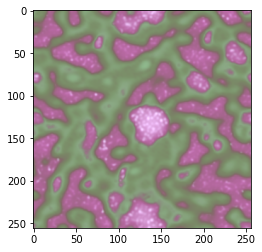

Generated sample @  9  iterations


KeyboardInterrupt: 

In [19]:
#run training
for n_iter in range(max_iter):
    optimizer.zero_grad()
    # element by element in the batch to allow the use of large training images
    for i in range(batch_size):
        sz = [img_size/1,img_size/2,img_size/4,img_size/8,img_size/16,img_size/32]
        zk = [torch.rand(1,n_input_ch,int(szk),int(szk)) for szk in sz]
        z_samples = [Variable(z.to(device)) for z in zk ]
        batch_sample = gen(z_samples)
        sample = batch_sample[0,:,:,:].unsqueeze(0)
        out = vgg(sample, loss_layers)
        if use_GN:
            losses = [w[a]*loss_fns[a](I(f), targets[a]) for a,f in enumerate(out)]
        else:
            losses = [w[a]*loss_fns[a](f, targets[a]) for a,f in enumerate(out)]
        single_loss = (1/(batch_size))*sum(losses)
        single_loss.backward(retain_graph=False)
        Loss[n_iter] = 0
        del out, losses, single_loss, batch_sample, z_samples, zk

    if n_iter%show_iter == (show_iter-1):
        print('Iteration: %d, loss: %f'%(n_iter, Loss[n_iter]))
        if disp:
            out_img = postp(sample.data.cpu().squeeze())
            out_img_array = numpy.asarray( out_img, dtype="int32" )
            plt.figure()
            plt.imshow(out_img_array)
            plt.show()
            print('Generated sample @ ', n_iter, ' iterations')

    if n_iter%save_params == (save_params-1):
        out_img = postp(sample.data.cpu().squeeze())
        out_img.save('./Trained_models/' + out_folder_name + '/training_'
                     + str(n_iter+1) + '.jpg', "JPEG")
    del sample


    if n_iter%save_params == (save_params-1):
        torch.save(gen, './Trained_models/' + out_folder_name
                   + '/trained_model_' + str(n_iter+1) + '.py')
        torch.save(gen.state_dict(), './Trained_models/' + out_folder_name
                   + '/params' + str(n_iter+1) + '.pytorch')

    optimizer.step()
    if optimizer.param_groups[0]['lr'] > min_lr:
        if n_iter%lr_adjust == (lr_adjust-1):
            optimizer.param_groups[0]['lr'] \
            = lr_decay_coef * optimizer.param_groups[0]['lr']
            print('---> lr adjusted to '+str(optimizer.param_groups[0]['lr']))

# save final model and training history
torch.save(gen,'./Trained_models/'+out_folder_name +'/trained_model.py')
torch.save(gen.state_dict(),'./Trained_models/'+out_folder_name+'/params.pytorch')
numpy.save('./Trained_models/'+out_folder_name+'/loss_history',Loss)


Text(0.5, 1.0, 'GRAM Loss during training')

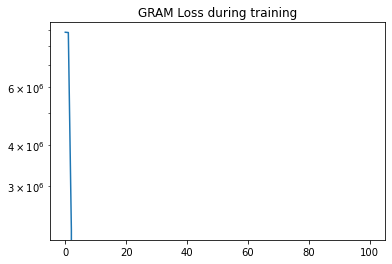

In [ ]:
# Plot loss
plt.semilogy(Loss)
plt.title("Perceptual Loss during training")

## 5 - Feed forward synthesis

In [ ]:
offline_size = 256
n_samples = 5
for param in gen.parameters():
    param.requires_grad = False
gen.eval()

sz = [offline_size/1,offline_size/2,offline_size/4,offline_size/8,offline_size/16,offline_size/32]
zk = [torch.rand(n_samples,n_input_ch,int(szk),int(szk)) for szk in sz]
z_samples = [Variable(z.to(device)) for z in zk ]
sample = gen(z_samples)
            
plt.figure()     
for n in range(n_samples):
    single_sample = sample[n,:,:,:]
    out_img = postp(single_sample.data.cpu().squeeze())
    out_img.save('./Trained_models/' + out_folder_name + '/offline_sample_'
                 + str(n) + '.jpg', "JPEG")
    
    out_img_array = numpy.asarray( out_img, dtype="int32" )
    plt.imshow(out_img_array)
    plt.axis('off')
    plt.title(f'Generated sample # {n}')
    plt.show()



## 6 - Questions

1. Read & Complete this notebook :
    1. complete the definition of the loss function using `GramMSELoss` combined with `GramMatrix` rather than `MSELoss`
    2. complete the training algorithm 
    3. plot the loss function
    4. synthesize random images by sampling the model image after training
2. Experiment with multiple images :
    1. with other textures images (see `./textures/` directory) 
    2. with non-stationnary images (such as a landscape) 
    3. try with larger and smaller image resolutions
    4. what the batch is representing here ? why using `batch_size` $>1$ when training with a single image ?


## 7 - Exercices

#### ablation study of the perceptual loss for NN training
- can you notice the influence of the pooling method in the VGG network ?
- describe & explain what happen when using directly the feature maps of VGG rather than the Gram matrices of feature maps ?
- describe & explain what happen when using a randomly initialized VGG network rather than a trained one ?

#### ablation study of the neural network architecture
- what is the influence of the generative network input(s) ? for instance, what happen when the inputs are fixed during training (but still random noise) ?
- what is the influence of the generative network weights initialisation ?
- describe & explain what happen when using only one scale (whitout the need for upsampling)
- describe & explain what happen when using a randomly initialized VGG network rather than a trained one ?
- what happen with another neural network architecture such as an MLP ?

#### ablation of the optimisation
- try different gradient descent optimisation algorithms (SGD, Adam, LBFGS ...)
- what is the role of the gradient normalisation ?

####  Comparaison with the Patch & Neural Texture optimisation methods (seen in lab #2 and lab #4). 
- Describes (using the perceptual loss and image comparison) the avantages and drawbacks of each approach
- Use the Patch-Match (seen in lab #2) to compute NN field between images (patch nearest neighbor correspondance map) to assess the originality of the synthesized images

#### [more challenging] using other features
- what happen if we use RGB features instead rather than VGG ? 
    - for instance, use directly color values of each pixel ?
    - what happen with color patches ?
    - compare with the Deep Image Prior approach (lab #3)